Ce document comporte des blocks de code Python. Les lignes suivantes permettent d'utiliser des fonctions mathématiques et des tableaux (`numpy`) et tracer des graphes (`matplotlib.pyplot`).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Échantillonnage du signal et spectre en fréquence

Dans l'énoncé, on parle d'un microphone dans l'habitacle enregistrant le son avec une fréquence d'échantillonnage $f_s$ de 2048 Hz : la valeur de la tension crée par l'électroaimant présent dans le microphone sous l'effet des variations de la pression acoustique est enregistrée toutes les ${1\over 2048}\approx 0,49\,\mathrm{ms}$. C'est ce que fait en réalité tous les instruments de mesure numérique, en particulier un microphone. Pour une durée d'enregistrement donnée, la _fréquence d'échantillonnage_ détermine en effet le nombre de valeurs enregistrées en l'espace d'une seconde, et est donc le paramètre selon lequel on peut juger de la fidélité d'un enregistrement.

On définit la fonction correspondant au signal $s(t)$ émis par la sirène, et on en construit un échantillon de 2 secondes.

In [2]:
def signal_func(t):
    """Fonction signal s(t)"""
    harm = [435,580] # fréquences des harmoniques
    amp = [1.,1/3] # amplitudes des harmoniques
    phas = [0.6,0] # phases associées
    return sum(
        am*np.cos(2*np.pi*f*t - ph) 
        for (am,f,ph) in zip(amp,harm,phas))

def echanti():
    """Construit l'échantillon du signal s(t)"""
    global fs
    fs = 2048 # fréquence d'échantillonnage
    global dt
    dt = 1/fs # pas d'échantillonnage
    global N
    N = 4096 # nombre d'échantillons
    global times
    times = np.linspace(0,N*dt,N+1) # points t_k d'échantillonnement de s(t) ;
    # on échantillonne donc sur N*dt = 2.0 secondes
    global signal_temp
    signal_temp = signal_func(times) # échantillons s_k = s(t_k)
echanti()

On effectue les tracés de $s(t)$ et de son spectre de Fourier.

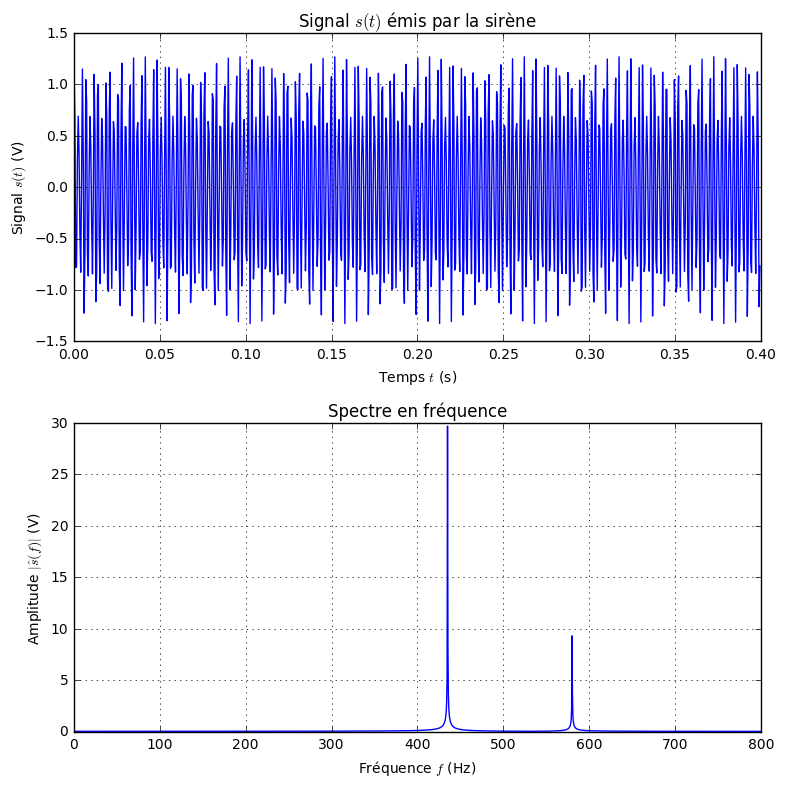

In [3]:
fig, ax = plt.subplots(2,1, figsize=(8,8))

def make_time(axi):
    """Construit le graphe de l'échantillon"""
    axi.set_title("Signal $s(t)$ émis par la sirène")
    axi.plot(times[:N//5],signal_temp[:N//5])
    axi.set_ylabel(r"Signal $s(t)$ (V)")
    axi.set_xlabel(r"Temps $t$ (s)")
    axi.grid()

def make_freq(axi):
    """Trace le graphe de la transformée de Fourier 
    rapide (FFT) de l'échantillon signal_temp"""
    signal_fr = np.fft.rfft(signal_temp,norm="ortho")
    freqs = np.linspace(0,fs/2,N//2+1)
    axi.plot(freqs,np.abs(signal_fr))
    axi.set_xlim(0,800)
    axi.set_xlabel("Fréquence $f$ (Hz)")
    axi.set_title("Spectre en fréquence")
    axi.set_ylabel(r"Amplitude $|\hat s(f)|$ (V)")
    #start, end = axi.get_xlim()
    #axi.xaxis.set_ticks(np.arange(start, end, 50))
    axi.grid()
    return freqs, signal_fr

make_time(ax[0])
freqs,signal_fr = make_freq(ax[1])
fig.tight_layout()
fig.savefig("sirene.pdf")

# Action de l'effet Doppler sur un signal composé

On sait quantifier comment l'effet Doppler agit sur un son pur : il modifie sa fréquence $f$ selon la formule donnée. Mais pour un signal composé comme ici, nous n'avons aucun moyen de procéder de façon directe.

L'idée est la suivante : on utilise le principe de décomposition de Fourier. En effet $s(t)$ est la somme de sons purs dont les caractéristiques — telles que la fréquence — sont données par son spectre.

Afin de savoir ce qu'il va faire au signal $s(t)$ émis par la sirène, il suffit donc de déterminer comment sera modifiée _chaque_ fréquence intervenant dans sa décomposition.

D'après le spectre donné, le signal $s(t)$ contient deux composantes harmoniques principales, de fréquences

$$
f_1 = 435\,\mathrm{Hz}\quad\text{et}\quad f_2 = 580\,\mathrm{Hz}.
$$

La vitesse du véhicule de police est $v=70\,\mathrm{km.h^{-1}} = 19,4\,\mathrm{m.s^{-1}}\approx 0.057c$ : on va éviter d'utiliser la formule approchée. Le produit scalaire vaut $\vec v\cdot\vec u= \|\vec v\|\cos(30°) = 19,4\times \frac{\sqrt 3}{2}$ (puisque $\|\vec u\| = 1$).

Les nouvelles fréquences sont donc, en utilisant la formule (2):

\begin{equation*}
    \begin{array}{ll}
    f_1' &= \dfrac{c}{c-\vec v\cdot\vec u}f_1 \\
         &= \dfrac{340}{340-19,4\times\cos(30°)}\times 435 
    = 458\,\mathrm{Hz}
    \end{array}\quad\text{et}\quad
    f_2' = 610\,\mathrm{Hz}.
\end{equation*}


# Spectre en fréquence et reconstitution du signal reçu

In [4]:
def doppled():
    freq_new = [458,610] # fréquences obtenues par effet Doppler
    u = list(zip(freqs,signal_fr))
    amps_c = [c[1] for c in u if c[0] in [435,580]]  
    # récupère les amplitudes des harmoniques initiaux
    amps, phas = (np.abs(amps_c),np.angle(amps_c)) 
    global Nr ; Nr = N
    global tia; tia = np.linspace(0,2,Nr+1)
    global fia; fia = np.linspace(0,fs/2,Nr//2+1)
    def four(fr):
        """Construit le spectre"""
        if fr in freq_new:
            i = freq_new.index(fr)
            return amps[i]*np.exp(2*np.pi*fr*1j-phas[i]*1j)
        else: 
            return 0
    
    global signal_rec_f; signal_rec_f = [four(fr) for fr in fia] # Spectre
    global signal_rec
    signal_rec = np.fft.irfft(signal_rec_f) # Signal reconstitué

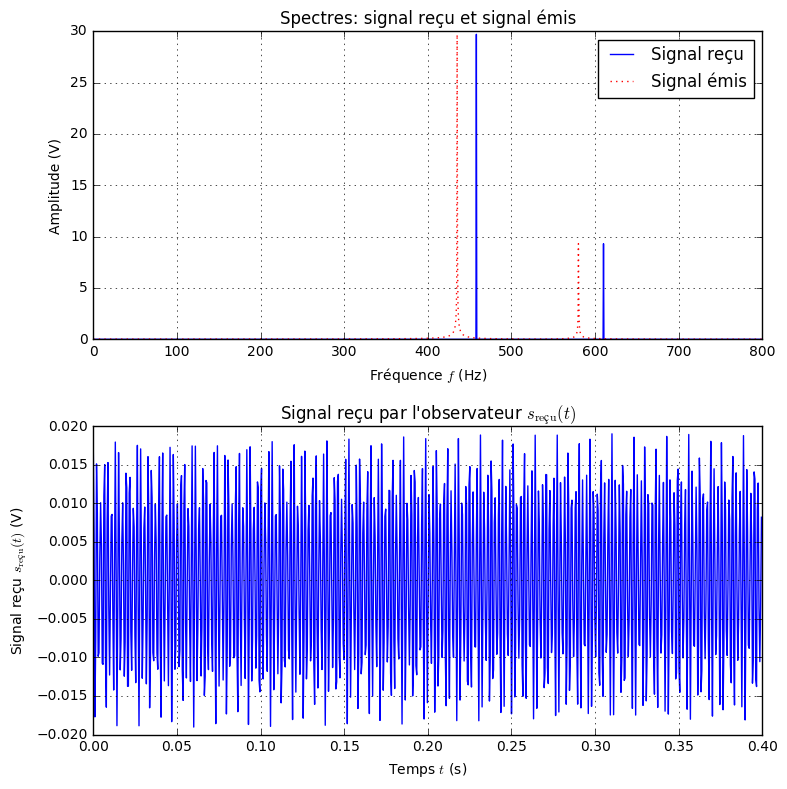

In [5]:
doppled()
fig,ax = plt.subplots(2,1, figsize=(8,8))
ax[0].grid()
ax[0].set_xlim(0,800)
ax[0].plot(fia,np.abs(signal_rec_f), label="Signal reçu")
ax[0].plot(fia,np.abs(signal_fr),'r:', label="Signal émis")
ax[0].legend()
ax[0].set_title("Spectres: signal reçu et signal émis")
ax[0].set_xlabel(r"Fréquence $f$ (Hz)")
ax[0].set_ylabel(r"Amplitude (V)")
ax[1].grid()
ax[1].plot(tia[:Nr//5],signal_rec[:Nr//5].real)
ax[1].set_title("Signal reçu par l'observateur $s_\mathrm{reçu}(t)$")
ax[1].set_xlabel(r"Temps $t$ (s)")
ax[1].set_ylabel(r"Signal reçu $s_\mathrm{reçu}(t)$ (V)")
fig.tight_layout()